In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sodapy import Socrata

"""
This notebook is designed to develop the relationship between mortality data due to cardiovascular desease
and defibrilator placements (medical and non-medical). Of course, AED will be used before death, but this data
could account for potential areas that have a higher degree of mortality due to cardiovascular desease. 
Analysis will be done considering comarcal geographical distributions, which is the highest resolution data
we have related to mortality rates.
Of course, AEDs can be used in other medical related deseases, but we will specially focus on cardiovascular 
due to the direct relationship.
"""



"""
The first step is to load the available data into the df and clean it. In dades.ipnyb the mortality data, 
defibrillator and hospital data was cleaned.
"""
client = Socrata("analisi.transparenciacatalunya.cat", None)
desfibriladors = client.get_all("wpud-ukyg")
hospitals = client.get_all("8gmd-gz7i")
df_desfibriladors = pd.DataFrame.from_records(desfibriladors) 
df_hospitals = pd.DataFrame.from_records(hospitals)

df_hospitals = df_hospitals[df_hospitals["categoria"].str.contains(r"Salut\|Centres", na=False)]
df_hospitals = df_hospitals.drop_duplicates(subset='idequipament', keep='first')


df_desfibriladors = df_desfibriladors.drop_duplicates(subset='numero_serie', keep='first')


url = "https://www.idescat.cat/serveis/consultes/ca/censph_10_mun_2024.csv"
df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


df_mortality = pd.read_csv("./Data/mortality.csv", sep=",", encoding="utf-8-sig")



/var/folders/_r/lv31y_xx5hzfyhbw22ddz7gr0000gn/T/ipykernel_73315/1201907718.py:36: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cens = pd.read_csv(url, sep=";", encoding="utf-8")


In [3]:
data_dir = "../carto/"

municipis = gpd.read_file(data_dir + "municipis.json")


In [4]:
"""
Now we want to count how many hospitals/AED we have per comarca, and create a df that contains these values
and merge it inot a gpd to have the correct idea.
We also add a column with the mortality per 1000 inh for men/women/total due to cardivascular desease
for each of the comarques.
"""

df_hospi = df_hospitals[['codi_municipi']]
df_desfi = df_desfibriladors[['codi_municipi']]

defi_count = df_desfi.groupby('codi_municipi').size().reset_index(name='num_defi')
hospi_count = df_hospi.groupby('codi_municipi').size().reset_index(name='num_hospi')

hospi_count


,codi_municipi,num_hospi
0,170010,1
1,170025,1
2,170031,1
3,170059,1
4,170062,1
...,...,...
495,83073,10
496,89024,2
497,89030,1
498,89045,5


In [5]:
municipis = municipis.rename(columns={'CODIMUNI': 'codi_municipi', 'NOMMUNI':'municipi', 'NOMCOMAR': 'comarca'})
municipis = municipis[['codi_municipi', 'municipi', 'comarca', 'geometry']]
municipis

,codi_municipi,municipi,comarca,geometry
0,080018,Abrera,Baix Llobregat,"MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5..."
1,080023,Aguilar de Segarra,Bages,"MULTIPOLYGON (((1.6085 41.76999, 1.60801 41.77..."
2,080039,Alella,Maresme,"MULTIPOLYGON (((2.28512 41.51534, 2.28501 41.5..."
3,080044,Alpens,Lluçanès,"MULTIPOLYGON (((2.09358 42.14245, 2.09225 42.1..."
4,080057,l'Ametlla del Vallès,Vallès Oriental,"MULTIPOLYGON (((2.24126 41.70273, 2.24178 41.7..."
...,...,...,...,...
942,439039,Camarles,Baix Ebre,"MULTIPOLYGON (((0.64239 40.82154, 0.64239 40.8..."
943,439044,l'Aldea,Baix Ebre,"MULTIPOLYGON (((0.60964 40.80699, 0.60855 40.8..."
944,439057,Salou,Tarragonès,"MULTIPOLYGON (((1.13541 41.10119, 1.13523 41.1..."
945,439060,l'Ampolla,Baix Ebre,"MULTIPOLYGON (((0.69184 40.85044, 0.69102 40.8..."


In [6]:
import unicodedata

def normalize(text):
    if isinstance(text, str):
        text = text.lower().strip()
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
        text = text.replace('-', ' ').replace("'", "").replace("’", "")
        return text
    return text

In [7]:
"""
Normalise municipal data to make sure all have the same codes
"""

municipis['codi_municipi'] = municipis['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
defi_count['codi_municipi'] = defi_count['codi_municipi'].astype(str).apply(
    lambda x: x[:-1] if len(x) == 6 else x
)
def fix_code(x):
    x = str(x)  # ensure string
    # Add leading zero if first digit is 8 and length < 6
    if x.startswith('8') and len(x) < 6:
        x = '0' + x
    # Truncate last digit if length is 6
    if len(x) == 6:
        x = x[:-1]
    return x

hospi_count['codi_municipi'] = hospi_count['codi_municipi'].apply(fix_code)

# Filter rows where edat == "total"
df_cens_total = df_cens[(df_cens["edat"] == "total") & (df_cens["sexe"] == "total")].copy()
df_cens_total = df_cens_total[df_cens_total["valor"] <= 5000000]
df_cens_total = df_cens_total.reset_index(drop=True)
df_cens_total = df_cens_total.rename(columns={"valor": "pob"})

# Keep only geo name and population
df_cens_pop = df_cens_total[["geo", "pob"]].copy()

df_cens_pop = df_cens_pop.rename(columns={'geo': 'codi_municipi'})
df_cens_pop['codi_municipi'] = df_cens_pop['codi_municipi'].apply(fix_code)



In [8]:
import numpy as np
"""
After all the data cleaning, we finally got to where we want to be, a data set that has municipi and comarca and the amount of
defibrillators and medical centers in each of these places.
"""

total = municipis.merge(defi_count, on='codi_municipi', how='left')
total = total.merge(hospi_count, on='codi_municipi', how='left')
total = total.merge(df_cens_pop, on='codi_municipi', how='left')

total = total.fillna(0)
total = total.replace([np.inf, -np.inf], 0)

print(total)

comarca_totals = total.groupby('comarca')[['num_defi', 'num_hospi', 'pob']].sum().reset_index()

print(comarca_totals)


    codi_municipi              municipi          comarca  \
0           08001                Abrera   Baix Llobregat   
1           08002    Aguilar de Segarra            Bages   
2           08003                Alella          Maresme   
3           08004                Alpens         Lluçanès   
4           08005  l'Ametlla del Vallès  Vallès Oriental   
..            ...                   ...              ...   
942         43903              Camarles        Baix Ebre   
943         43904               l'Aldea        Baix Ebre   
944         43905                 Salou       Tarragonès   
945         43906             l'Ampolla        Baix Ebre   
946         43907            la Canonja       Tarragonès   

                                              geometry  num_defi  num_hospi  \
0    MULTIPOLYGON (((1.92486 41.53663, 1.92197 41.5...      43.0        0.0   
1    MULTIPOLYGON (((1.6085 41.76999, 1.60801 41.77...       0.0        0.0   
2    MULTIPOLYGON (((2.28512 41.51534, 2.2

In [10]:
"""
Now comes the cleaning and doing with the medical data. we can select a df when choosing one of 
keys, this allows us to save the whole cleaned df in a compact way. We select one of the death
causes, like Circ (circulatory problems) or Tot (Total). Since these values are death rates, we
should multiply them by the probability that a AED has been used...

From data in OHSCAR, we have that cardiac arrests constitute 45.8/100,000 inhabitants for 2021 in
Catalunya. This means, that a rough estimate is that comarca_pob * cardiac_arrest gives us the
desired data. We can compare this with Circ or other death causes. These cardiac arrests values are
out of hospital cardiac arrests, so work better for DEAs. 
To make it more comarcal-like, assume that every cardiac arrest would result in death if untreated,
then we calculate the percentatge of cardiac_arrests/total_circ_death, which gives us a % where DEAS 
can be used. Then, we scale to each comarcal circ_death.
"""
df_cardio = df_mortality[df_mortality['Cause'].str.contains('Circ', case=False, na=False)]

sexes = ["Total", "Dones", "Homes"]

dfs = {}
for name in sexes:
    df = (df_cardio[df_cardio['Sexe'] == name]
          .drop(columns=["Sexe", "Cause"])
          .rename(columns={'Comarca':'comarca'})
          .reset_index(drop=True))
    df['comarca'] = df['comarca'].replace({'ARAN': "VAL DARAN"})
    df['comarca'] = df['comarca'].apply(normalize)
    dfs[name] = df

mortality_totals = dfs["Total"]
mortality_women  = dfs["Dones"]
mortality_men    = dfs["Homes"]

mortality_women

,comarca,< 1,1-4,5-14,15-24,25-34,35-44,45-54,55-64,65-74,...,5-14 rel,15-24 rel,25-34 rel,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel
0,alt camp,0,0,0,0,0,0,0,3,6,...,0.0,0.0,0.00,0.00,0.00,92.99,256.52,481.06,3376.91,211.56
1,alt emporda,0,0,0,0,0,1,0,3,12,...,0.0,0.0,0.00,9.60,0.00,30.62,159.77,674.87,3699.90,214.64
2,alt penedes,0,0,0,0,0,0,2,5,5,...,0.0,0.0,0.00,0.00,20.99,67.14,88.83,372.04,3663.69,183.66
3,alt urgell,0,0,0,0,0,0,1,1,2,...,0.0,0.0,0.00,0.00,60.35,63.61,177.15,248.76,4912.28,327.24
4,alta ribagorca,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,4255.32,207.47
5,anoia,0,0,0,0,0,0,1,3,6,...,0.0,0.0,0.00,0.00,9.65,36.61,93.49,716.60,3549.82,203.99
6,bages,0,0,0,0,0,0,0,7,11,...,0.0,0.0,0.00,0.00,0.00,56.46,111.48,630.55,4485.20,285.32
7,baix camp,0,0,0,0,1,2,1,4,20,...,0.0,0.0,9.13,13.85,6.05,29.30,188.68,490.49,3341.55,177.87
8,baix ebre,0,0,0,0,0,0,2,5,4,...,0.0,0.0,0.00,0.00,33.18,89.56,87.41,774.04,4465.16,317.96
9,baix emporda,0,0,0,0,0,1,0,5,7,...,0.0,0.0,0.00,10.40,0.00,49.07,87.88,606.06,4610.44,242.70


In [19]:
"""
We compute the data but now based on comarca and we eliminate llucanes comarca, because it is newer
than older df. We have to take into account that this comarca is small.

Then, we compute the cardiac which essetially is the percentatge of circ deaths per comarca that 
could be caused by a cardia arrest. if we take into account that 45.8/100,000 cases in catalunya,
this is approx: 8.012.231 population gives 3.670 cardiac arrest, which represent a 22.38% of total
circ deaths (16.400). We take this value to calcualte cardiac rel
"""
comarca_totals['comarca'] = comarca_totals['comarca'].apply(normalize)
comarca_totals = comarca_totals[comarca_totals['comarca'] != 'llucanes'].copy()


mortality_dfs = {
    "total": mortality_totals,
    "women": mortality_women,
    "men": mortality_men
}

df_comarques = {}

for key, df_mort in mortality_dfs.items():
    df_comarques[key] = comarca_totals.merge(
        df_mort,
        on='comarca',
        how='left'
    )
    df_comarques[key]["cardiac rel"] = df_comarques[key]["Total rel"]*(3670/16400)
    
df_comarques_total = df_comarques["total"]
df_comarques_women = df_comarques["women"]
df_comarques_men   = df_comarques["men"]

df_comarques_total


,comarca,num_defi,num_hospi,pob,< 1,1-4,5-14,15-24,25-34,35-44,...,15-24 rel,25-34 rel,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel,cardiac rel
0,alt camp,64.0,13.0,46388,0,0,0,0,1,0,...,0.00,20.36,0.00,13.40,91.66,257.12,756.83,3330.92,192.59,43.097884
1,alt emporda,282.0,45.0,148732,0,0,0,0,0,1,...,0.00,0.00,4.77,33.98,70.64,246.74,931.95,3737.69,211.23,47.269152
2,alt penedes,236.0,22.0,114189,0,0,1,0,0,0,...,0.00,0.00,0.00,30.19,85.89,202.84,711.22,3836.63,188.78,42.245280
3,alt urgell,53.0,21.0,21128,0,0,0,0,0,0,...,0.00,0.00,0.00,60.08,192.12,215.70,689.18,5079.01,325.53,72.847262
4,alta ribagorca,15.0,7.0,4040,0,0,0,0,0,0,...,0.00,0.00,0.00,136.05,167.50,0.00,448.43,2325.58,173.70,38.870671
5,anoia,441.0,18.0,128432,0,0,0,0,0,3,...,0.00,0.00,16.88,31.97,60.24,260.54,876.85,3874.73,208.44,46.644805
6,bages,258.0,27.0,185352,0,0,0,0,0,1,...,0.00,0.00,3.99,33.30,120.87,236.31,754.10,4440.50,259.34,58.035232
7,baix camp,211.0,34.0,204458,0,0,0,0,2,2,...,0.00,9.14,7.06,32.74,104.13,282.47,694.44,3391.05,183.19,40.994348
8,baix ebre,134.0,22.0,82399,0,0,0,0,0,1,...,0.00,0.00,8.94,31.19,161.16,180.40,967.90,4233.30,285.97,63.994506
9,baix emporda,232.0,25.0,143443,0,0,0,0,0,2,...,0.00,0.00,10.40,4.31,97.75,206.83,753.80,4614.66,226.84,50.762366


In [153]:
"""
We read comarques geopandas and merge it with total to get the polygons and be able to plot it
"""
comarques = gpd.read_file(data_dir + "comarca.json")

comarques = comarques[["NOMCOMAR","geometry"]].rename(columns={"NOMCOMAR":"comarca"})
comarques['comarca'] = comarques['comarca'].apply(normalize)

df_mort_com = {}

for key, df_com in df_comarques.items():
    merged = comarques.merge(
        df_com,
        on='comarca',
        how='left'
    )
    merged = gpd.GeoDataFrame(merged, geometry='geometry')

    # Fill missing values
    merged = merged.fillna(0)

    df_mort_com[key] = merged

"""
These df contain the information per comarca to a specific death cause. 
"""
df_mort_com_total = df_mort_com["total"]
df_mort_com_women = df_mort_com["women"]
df_mort_com_men   = df_mort_com["men"]

df_mort_com_total

,comarca,geometry,num_defi,num_hospi,pob,< 1,1-4,5-14,15-24,25-34,...,15-24 rel,25-34 rel,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel,cardiac rel
0,alt camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",64.0,13.0,46388.0,0.0,0.0,0.0,0.0,1.0,...,0.00,20.36,0.00,13.40,91.66,257.12,756.83,3330.92,192.59,43.097884
1,alt emporda,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",282.0,45.0,148732.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,4.77,33.98,70.64,246.74,931.95,3737.69,211.23,47.269152
2,alt penedes,"MULTIPOLYGON (((1.63329 41.50721, 1.63315 41.5...",236.0,22.0,114189.0,0.0,0.0,1.0,0.0,0.0,...,0.00,0.00,0.00,30.19,85.89,202.84,711.22,3836.63,188.78,42.245280
3,alt urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.31775 41.9...",53.0,21.0,21128.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,60.08,192.12,215.70,689.18,5079.01,325.53,72.847262
4,alta ribagorca,"MULTIPOLYGON (((0.88075 42.63108, 0.88052 42.6...",15.0,7.0,4040.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,136.05,167.50,0.00,448.43,2325.58,173.70,38.870671
5,anoia,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",441.0,18.0,128432.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,16.88,31.97,60.24,260.54,876.85,3874.73,208.44,46.644805
6,bages,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",258.0,27.0,185352.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,3.99,33.30,120.87,236.31,754.10,4440.50,259.34,58.035232
7,baix camp,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",211.0,34.0,204458.0,0.0,0.0,0.0,0.0,2.0,...,0.00,9.14,7.06,32.74,104.13,282.47,694.44,3391.05,183.19,40.994348
8,baix ebre,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",134.0,22.0,82399.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,8.94,31.19,161.16,180.40,967.90,4233.30,285.97,63.994506
9,baix emporda,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",232.0,25.0,143443.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,10.40,4.31,97.75,206.83,753.80,4614.66,226.84,50.762366


In [154]:
"""
We compute the AED coverage per 100.000k inhabitants. Important:
· Consider only AED locations, very different of being in a hospital from behind at home
· Cardiac arrest data was for Out of Hospital, so much better rationale.
"""


for key, df in df_mort_com.items():

    # Convert columns to numeric
    df['num_defi']   = pd.to_numeric(df['num_defi'], errors='coerce').fillna(0)
    df['num_hospi']  = pd.to_numeric(df['num_hospi'], errors='coerce').fillna(0)
    df['pob']        = pd.to_numeric(df['pob'], errors='coerce').fillna(0)
    df['Total rel']  = pd.to_numeric(df['Total rel'], errors='coerce').fillna(0)

    # Compute coverage per 100k
    df['coverage_desfi'] = np.where(
        df['pob'] > 0,
        (df['num_defi']) / df['pob'] * 100000,
        0
    )
    df['coverage_hospi'] = np.where(
        df['pob'] > 0,
        (df['num_hospi']) / df['pob'] * 100000,
        0
    )
    df_mort_com[key] = df

df_mort_com_total

,comarca,geometry,num_defi,num_hospi,pob,< 1,1-4,5-14,15-24,25-34,...,35-44 rel,45-54 rel,55-64 rel,65-74 rel,75-84 rel,>84 rel,Total rel,cardiac rel,coverage_desfi,coverage_hospi
0,alt camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",64.0,13.0,46388.0,0.0,0.0,0.0,0.0,1.0,...,0.00,13.40,91.66,257.12,756.83,3330.92,192.59,43.097884,137.966716,28.024489
1,alt emporda,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",282.0,45.0,148732.0,0.0,0.0,0.0,0.0,0.0,...,4.77,33.98,70.64,246.74,931.95,3737.69,211.23,47.269152,189.602775,30.255762
2,alt penedes,"MULTIPOLYGON (((1.63329 41.50721, 1.63315 41.5...",236.0,22.0,114189.0,0.0,0.0,1.0,0.0,0.0,...,0.00,30.19,85.89,202.84,711.22,3836.63,188.78,42.245280,206.674899,19.266304
3,alt urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.31775 41.9...",53.0,21.0,21128.0,0.0,0.0,0.0,0.0,0.0,...,0.00,60.08,192.12,215.70,689.18,5079.01,325.53,72.847262,250.851950,99.394169
4,alta ribagorca,"MULTIPOLYGON (((0.88075 42.63108, 0.88052 42.6...",15.0,7.0,4040.0,0.0,0.0,0.0,0.0,0.0,...,0.00,136.05,167.50,0.00,448.43,2325.58,173.70,38.870671,371.287129,173.267327
5,anoia,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",441.0,18.0,128432.0,0.0,0.0,0.0,0.0,0.0,...,16.88,31.97,60.24,260.54,876.85,3874.73,208.44,46.644805,343.372368,14.015199
6,bages,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",258.0,27.0,185352.0,0.0,0.0,0.0,0.0,0.0,...,3.99,33.30,120.87,236.31,754.10,4440.50,259.34,58.035232,139.194613,14.566878
7,baix camp,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",211.0,34.0,204458.0,0.0,0.0,0.0,0.0,2.0,...,7.06,32.74,104.13,282.47,694.44,3391.05,183.19,40.994348,103.199679,16.629332
8,baix ebre,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",134.0,22.0,82399.0,0.0,0.0,0.0,0.0,0.0,...,8.94,31.19,161.16,180.40,967.90,4233.30,285.97,63.994506,162.623333,26.699353
9,baix emporda,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",232.0,25.0,143443.0,0.0,0.0,0.0,0.0,0.0,...,10.40,4.31,97.75,206.83,753.80,4614.66,226.84,50.762366,161.736718,17.428526


In [155]:
"""
We compute the cardiac norm and coverage norm per comarca. This value is related to the z-score for
proper normalising a better understanding. This way, both have no units and are better plotted
one with the other.
"""

cause = "cardiac rel"
def normalise_zscore(df_mort_com):
    for key, df in df_mort_com.items():
    
        zeros = df[cause] == 0
        non_zeros = ~zeros
    
        # Mean only over non-zero values
        mean_cause = df.loc[non_zeros, cause].mean()
        std_cause  = df.loc[non_zeros, cause].std()
    
        df[f'{cause} norm'] = 0.0
        if std_cause != 0:
            df.loc[non_zeros, f'{cause} norm'] = (df.loc[non_zeros, cause] - mean_cause) / std_cause
    
        # ---- COVERAGE NORM ----
        mean_cov = df['coverage_per_100k'].mean()
        std_cov  = df['coverage_per_100k'].std()
    
        df['coverage_norm'] = 0.0
        if std_cov != 0:
            df['coverage_norm'] = (df['coverage_per_100k'] - mean_cov) / std_cov
    
        df_mort_com[key] = df
    return df_mort_com

def normalize_second_extreme(df, col, zero_mask=None):
    if zero_mask is None:
        zero_mask = (df[col] == 0)
    nonzero_mask = ~zero_mask
    
    centered = df.loc[nonzero_mask, col] - df.loc[nonzero_mask, col].mean()
    sorted_vals = np.sort(centered.values)
    
    if len(sorted_vals) < 3:
        raise ValueError("Need at least 3 non-zero values to use second extremes.")
    
    min_val = sorted_vals[1]
    max_val = sorted_vals[-2]
    scale = max(abs(min_val), abs(max_val))

    norm_col = f"{col}_norm"
    df[norm_col] = 0.0
    if scale != 0:
        df.loc[nonzero_mask, norm_col] = np.clip(centered / scale, -1, 1)

    return df

def normalise_maxabs(df_mort_com, cause='cardiac rel', desfi='coverage_desfi', hospi = 'coverage_hospi', pop='pob', low=3, high=98):
    for key, df in df_mort_com.items():
        
        zeros = df[cause] == 0
        non_zeros = ~zeros
        
        # --- Cause normalization ---
        centered_cause = df.loc[non_zeros, cause] - df.loc[non_zeros, cause].mean()
        max_abs_cause = centered_cause.abs().max()
        df[f'{cause} norm'] = 0.0
        if max_abs_cause != 0:
            df.loc[non_zeros, f'{cause} norm'] = centered_cause / max_abs_cause

        df = normalize_second_extreme(df, pop , zero_mask = zeros)
        df = normalize_second_extreme(df, desfi, zero_mask = zeros)
        df = normalize_second_extreme(df, hospi, zero_mask = zeros)
        
        return df_mort_com


df_mort_com = normalise_maxabs(df_mort_com)


df_mort_com_total

,comarca,geometry,num_defi,num_hospi,pob,< 1,1-4,5-14,15-24,25-34,...,75-84 rel,>84 rel,Total rel,cardiac rel,coverage_desfi,coverage_hospi,cardiac rel norm,pob_norm,coverage_desfi_norm,coverage_hospi_norm
0,alt camp,"MULTIPOLYGON (((1.47594 41.47798, 1.47459 41.4...",64.0,13.0,46388.0,0.0,0.0,0.0,0.0,1.0,...,756.83,3330.92,192.59,43.097884,137.966716,28.024489,-0.298586,-0.187475,-0.411392,-0.113941
1,alt emporda,"MULTIPOLYGON (((3.17533 42.11147, 3.17536 42.1...",282.0,45.0,148732.0,0.0,0.0,0.0,0.0,0.0,...,931.95,3737.69,211.23,47.269152,189.602775,30.255762,-0.177479,-0.054457,-0.099038,-0.096416
2,alt penedes,"MULTIPOLYGON (((1.63329 41.50721, 1.63315 41.5...",236.0,22.0,114189.0,0.0,0.0,1.0,0.0,0.0,...,711.22,3836.63,188.78,42.245280,206.674899,19.266304,-0.323340,-0.099353,0.004234,-0.182730
3,alt urgell,"MULTIPOLYGON (((1.31941 41.99157, 1.31775 41.9...",53.0,21.0,21128.0,0.0,0.0,0.0,0.0,0.0,...,689.18,5079.01,325.53,72.847262,250.851950,99.394169,0.565146,-0.220305,0.271468,0.446613
4,alta ribagorca,"MULTIPOLYGON (((0.88075 42.63108, 0.88052 42.6...",15.0,7.0,4040.0,0.0,0.0,0.0,0.0,0.0,...,448.43,2325.58,173.70,38.870671,371.287129,173.267327,-0.421317,-0.242515,1.000000,1.000000
5,anoia,"MULTIPOLYGON (((1.43708 41.8012, 1.4355 41.801...",441.0,18.0,128432.0,0.0,0.0,0.0,0.0,0.0,...,876.85,3874.73,208.44,46.644805,343.372368,14.015199,-0.195606,-0.080841,0.831139,-0.223973
6,bages,"MULTIPOLYGON (((2.00146 41.96643, 1.99983 41.9...",258.0,27.0,185352.0,0.0,0.0,0.0,0.0,0.0,...,754.10,4440.50,259.34,58.035232,139.194613,14.566878,0.135099,-0.006862,-0.403965,-0.219640
7,baix camp,"MULTIPOLYGON (((1.03706 41.0577, 1.03707 41.05...",211.0,34.0,204458.0,0.0,0.0,0.0,0.0,2.0,...,694.44,3391.05,183.19,40.994348,103.199679,16.629332,-0.359659,0.017971,-0.621704,-0.203441
8,baix ebre,"MULTIPOLYGON (((0.77083 40.76315, 0.77095 40.7...",134.0,22.0,82399.0,0.0,0.0,0.0,0.0,0.0,...,967.90,4233.30,285.97,63.994506,162.623333,26.699353,0.308118,-0.140671,-0.262241,-0.124349
9,baix emporda,"MULTIPOLYGON (((2.97554 41.75367, 2.97555 41.7...",232.0,25.0,143443.0,0.0,0.0,0.0,0.0,0.0,...,753.80,4614.66,226.84,50.762366,161.736718,17.428526,-0.076058,-0.061331,-0.267604,-0.197164


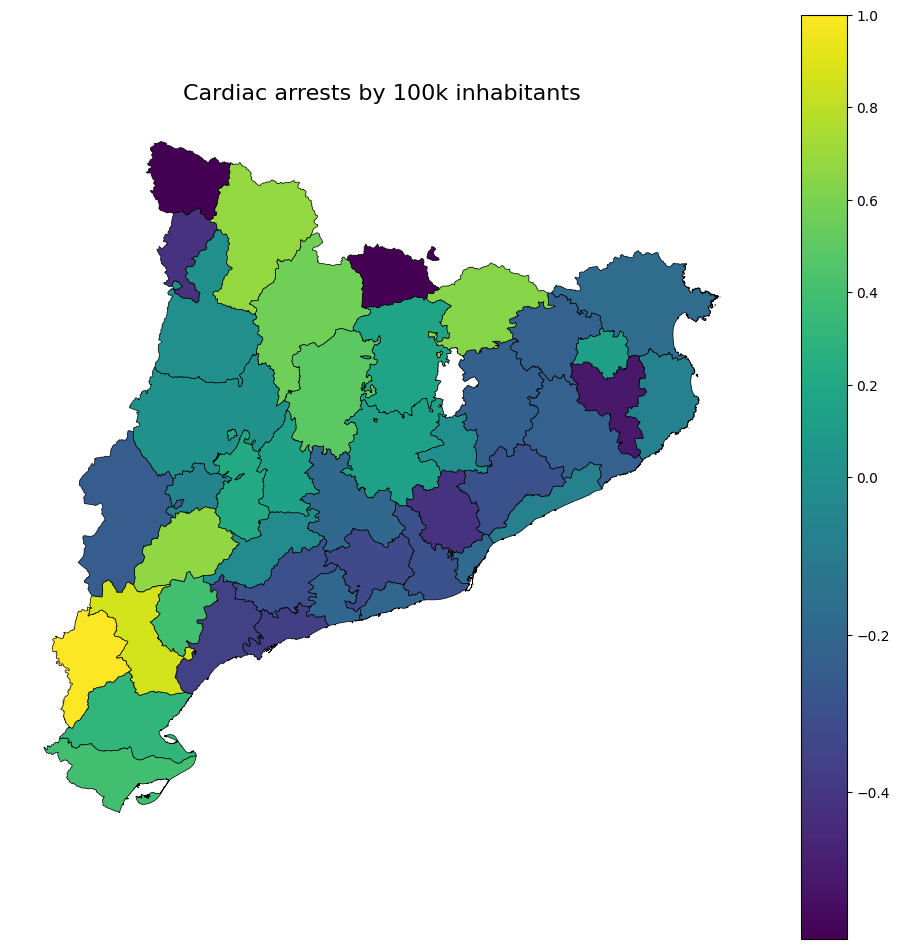

In [125]:
import colorcet as cc
import matplotlib.colors as mcolors

cause = "cardiac rel norm"
df_plot = df_mort_com_total.copy()

zeros = df[cause] == 0
non_zeros = ~zeros

vals = df[f'{cause}']

cmap = plt.cm.viridis

# Create a TwoSlopeNorm centered at 0
vmin = vals.min()
vmax = vals.max()
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

fig, ax = plt.subplots(figsize=(12, 12))

# Plot non-zero municipalities
df_plot[non_zeros].plot(
    column=f'{cause}',
    cmap=cmap,
    norm = norm,# color map for positive values (cc.cm["dimgray_r"])
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

# Plot zeros in grey on top
df_plot[zeros].plot(
    color='white',
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Cardiac arrests by 100k inhabitants', fontsize=16)
ax.axis('off')
plt.show()


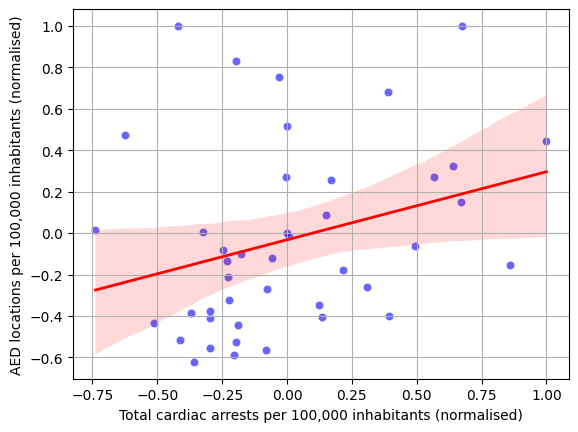

In [127]:
import seaborn as sns
"""
We compute a relationship between cardiac arrests and AED quantities
"""
cov = "coverage_norm"
# Scatter with ALL data

sns.scatterplot(
    data=df_plot,
    y=f'{cov}',
    x=f'{cause}',
    alpha=0.6,
    color='blue'
)


# Regression ONLY on filtered data
sns.regplot(
    data=df_plot,
    y=f'{cov}',
    x=f'{cause}',
    scatter=False,      # do NOT plot points again
    ci=95,
    color='red',
    line_kws={'linewidth':2}
)
plt.ylabel('AED locations per 100,000 inhabitants (normalised)')
plt.xlabel('Total cardiac arrests per 100,000 inhabitants (normalised)')
#plt.title('Coverage vs Cardiovascular Deaths per Comarca with Trend and CI')
plt.grid(True)
plt.show()

In [128]:
from scipy.stats import linregress
from scipy.stats import norm

"""
We compute the regression coefficients for points that we don't consider as outliers, so their
coverage enters a 95 interval of confidence, and we find the results

"""


# Confidence level
conf = 0.95
z = norm.ppf((1 + conf) / 2)
mean_cov = df_plot[f'{cov}'].mean()
std_cov  = df_plot[f'{cov}'].std()
lower = mean_cov - z * std_cov
upper = mean_cov + z * std_cov

# Filter values within CI
df_plot = df_plot[(df_plot[f'{cov}'] >= lower) &
                    (df_plot[f'{cov}'] <= upper)]


res = linregress(
    y = df_plot[f'{cov}'],
    x = df_plot[f'{cause}']
)

print("Slope:", res.slope)
print("Intercept:", res.intercept)
print("R²:", res.rvalue**2)
print("p-value:", res.pvalue)
print("Std err:", res.stderr)

Slope: 0.317373422927102
Intercept: -0.0805711487926135
R²: 0.10170804812899933
p-value: 0.04212081280927431
Std err: 0.15103212980332162


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
import geopandas as gpd

def adjust_color_for_diagonal(color, x_center, y_center):
    """
    Brighten color if y > x, darken if y < x.
    x_center, y_center = bin center values.
    """
    r, g, b, a = color

    # Compare diagonal
    if y_center > x_center:      # above diagonal → brighten
        factor = 1.25
    elif y_center < x_center:    # below diagonal → darken
        factor = 0.75
    else:
        factor = 1.0

    r = min(1, r * factor)
    g = min(1, g * factor)
    b = min(1, b * factor)

    return (r, g, b, a)


def bivariate_choropleth(
    df,
    cause,
    cov,
    num_bins=6,
    cmap_name='cividis',
    figsize=(12, 12),
    inset_size=("30%", "30%"),
    inset_loc='lower right'
):
    """
    Draws a 6×6 bivariate choropleth with an inset scatter plot.

    Adds two columns to df:
        - 'bin_idx'
        - 'plot_color'
    """

    df_plot = df.copy()

    x = df_plot[cause].values
    y = df_plot[cov].values

    # Identify zero–zero cases
    zeros = (x == 0) & (y == 0)
    nonzero_mask = ~zeros
    x_nonzero = x[nonzero_mask]
    y_nonzero = y[nonzero_mask]

    # Bin ranges
    x_min, x_max = np.floor(x_nonzero.min()), np.ceil(x_nonzero.max())
    y_min, y_max = np.floor(y_nonzero.min()), np.ceil(y_nonzero.max())

    x_bins = np.linspace(x_min, x_max, num_bins + 1)
    y_bins = np.linspace(y_min, y_max, num_bins + 1)

    # Digitize non-zero values
    x_idx = np.digitize(x_nonzero, x_bins, right=True) - 1
    y_idx = np.digitize(y_nonzero, y_bins, right=True) - 1

    x_idx = np.clip(x_idx, 0, num_bins - 1)
    y_idx = np.clip(y_idx, 0, num_bins - 1)

    bin_idx = y_idx * num_bins + x_idx

    """
    # Create discrete color palette
    cmap_cont = colormaps.get_cmap(cmap_name)
    colors = [cmap_cont(i / (num_bins**2 - 1)) for i in range(num_bins**2)]
    """
    
    # Create discrete color palette
    cmap_cont = colormaps.get_cmap(cmap_name)
    colors = []
    for j in range(num_bins):
        for i in range(num_bins):
            base_color = cmap_cont((j*num_bins + i) / (num_bins**2 - 1))
            
            # bin center coordinates
            x_center = (x_bins[i] + x_bins[i+1]) / 2
            y_center = (y_bins[j] + y_bins[j+1]) / 2
    
            adj_color = adjust_color_for_diagonal(base_color, x_center, y_center)
            colors.append(adj_color)
    
    # Assign colors to all comarcas
    plot_colors = []
    nz_i = 0
    for zero in zeros:
        if zero:
            plot_colors.append('white')
        else:
            plot_colors.append(colors[bin_idx[nz_i]])
            nz_i += 1

    # Add to dataframe
    full_bin_idx = np.zeros(len(df_plot), dtype=int)
    full_bin_idx[nonzero_mask] = bin_idx
    df_plot['bin_idx'] = full_bin_idx
    df_plot['plot_color'] = plot_colors

    df_plot['diag_relation'] = np.where(
        df_plot[f'{cov}'] > df_plot[f'{cause}'],  # y > x
        'above',
        np.where(
            df_plot[f'{cov}'] < df_plot[f'{cause}'],  # y < x
            'below',
            'equal'
        )
    )
    hatch_map = {
        'above': '|',    # vertical lines
        'below': '-',    # horizontal lines
        'equal': ''      # no hatch or '+'
    }

    # --- PLOT ---
    fig, ax_map = plt.subplots(figsize=figsize)

    
    df_plot.plot(
        color=df_plot['plot_color'],
        ax=ax_map,
        edgecolor='black',
        linewidth=0.5
    )
    """
    for idx, row in df_plot.iterrows():
        color = row['plot_color']   # already computed bin color
        hatch = hatch_map[row['diag_relation']]
        
        poly = gpd.GeoSeries([row.geometry])

        # 1. base fill
        poly.plot(
            ax=ax_map,
            facecolor=color,
            edgecolor='black',
            linewidth=0.3
        )
        
        # 2. fake hatch using colored stripes
        if row['diag_relation'] == 'above':     # vertical stripes
            poly.plot(
                ax=ax_map,
                facecolor='none',
                edgecolor=color,
                linewidth=1,
                linestyle=(0, (1, 4))  # short dash pattern
            )
        elif row['diag_relation'] == 'below':   # horizontal stripes
            poly.plot(
                ax=ax_map,
                facecolor='none',
                edgecolor=color,
                linewidth=1,
                linestyle=(0, (4, 1))  # long dash pattern
            )
    """
    ax_map.axis('off')
    ax_map.set_title(f"Bivariate {num_bins}×{num_bins} Choropleth", fontsize=14)

    # --- Inset scatter ---
    ax_inset = inset_axes(
        ax_map,
        width=inset_size[0],
        height=inset_size[1],
        loc=inset_loc,
        borderpad=1
    )

    # Background grid
    for i in range(num_bins):
        for j in range(num_bins):
            rect_color = colors[j*num_bins + i]
            ax_inset.add_patch(
                plt.Rectangle(
                    (x_bins[i], y_bins[j]),
                    x_bins[i+1] - x_bins[i],
                    y_bins[j+1] - y_bins[j],
                    facecolor=rect_color,
                    edgecolor='white',
                    alpha=0.7
                )
            )

    # Red x = y diagonal
    ax_inset.plot(
        [x_min, x_max],
        [y_min, y_max],
        color='red',
        linestyle='--',
        linewidth=1
    )

    # Scatter points
    ax_inset.scatter(
        x_nonzero,
        y_nonzero,
        c=[colors[i] for i in bin_idx],
        edgecolor='k',
        alpha=0.8
    )

    # Axes settings
    ax_inset.set_xticks(x_bins)
    ax_inset.set_yticks(y_bins)
    ax_inset.set_xlim(x_min, x_max)
    ax_inset.set_ylim(y_min, y_max)

    for spine in ax_inset.spines.values():
        spine.set_visible(False)

    ax_inset.set_xlabel(cause, fontsize=8)
    ax_inset.set_ylabel(cov, fontsize=8)
    ax_inset.tick_params(axis='both', labelsize=8)

    plt.show()


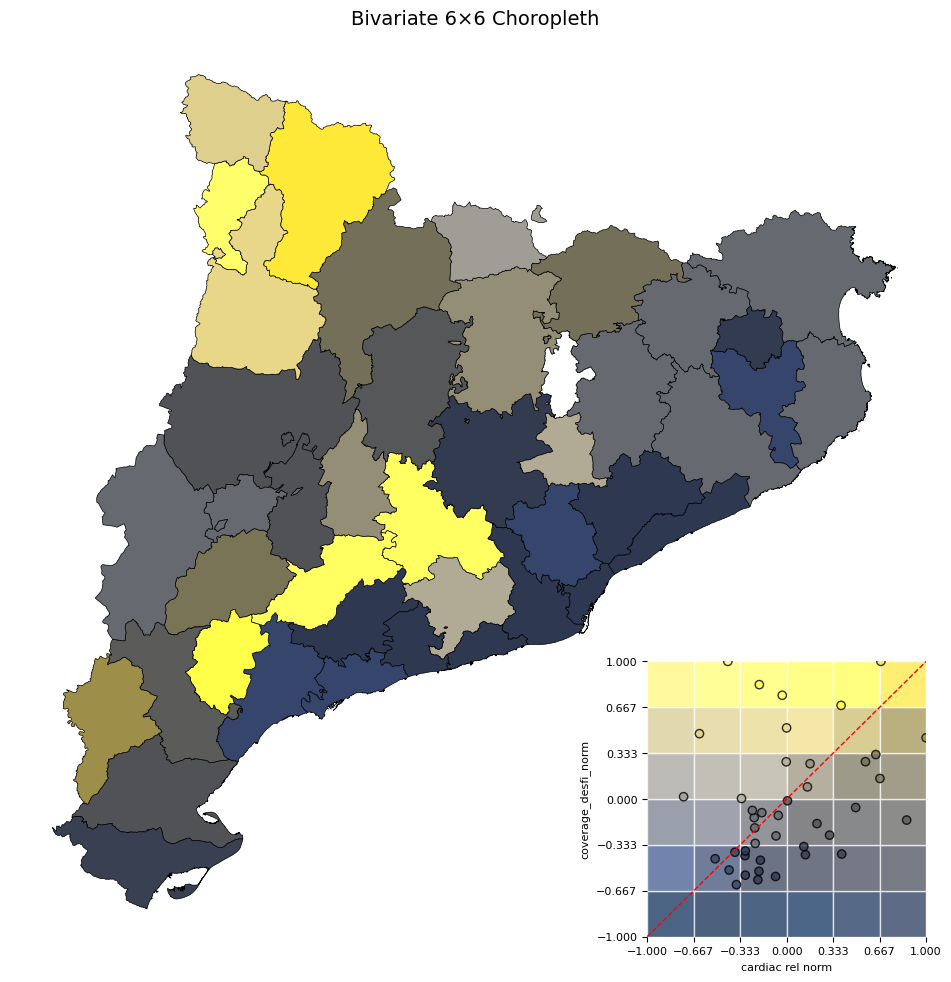

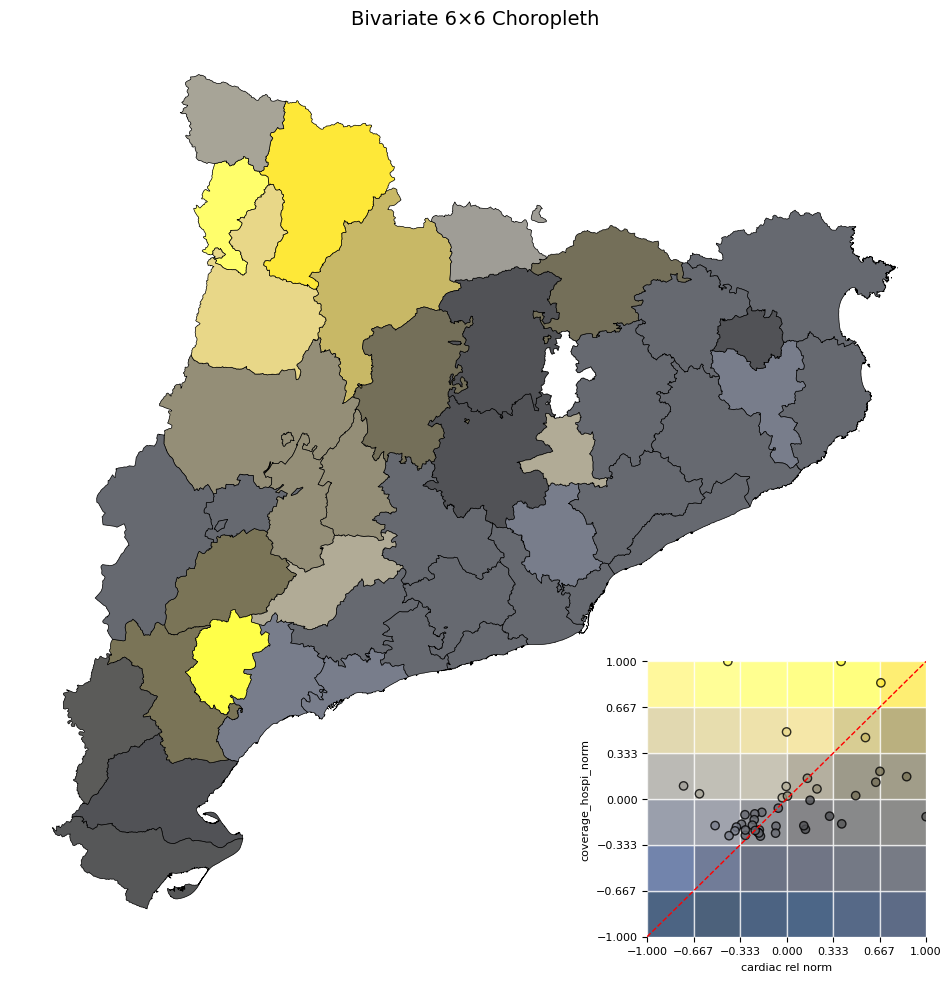

In [177]:
from matplotlib import colormaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cause = "cardiac rel norm"
desfi = "coverage_desfi_norm"
hospi = "coverage_hospi_norm"

bivariate_choropleth(
    df_mort_com_total,
    cause=cause,
    cov=desfi,
    num_bins=6
)

bivariate_choropleth(
    df_mort_com_total,
    cause=cause,
    cov=hospi,
    num_bins=6
)


We see in the above plot that there are many points below the cardiac arrests with AED coverage. This essentially means that all thos points have more cardiac arrests than the expected AED coverage accounts for. More over, we can also compare this with a population vs cardiac arrest plot:

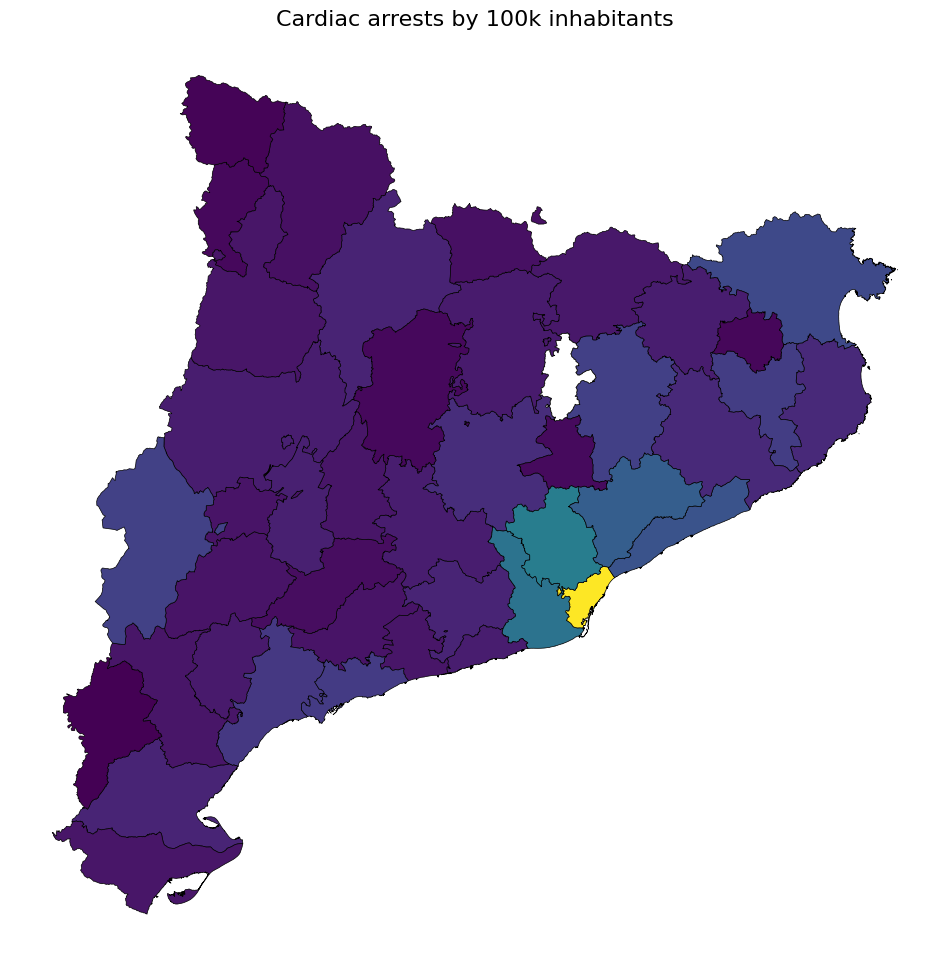

In [149]:

pop = "num_hospi"
df_plot = df_mort_com_total.copy()

zeros = df_plot[pop] == 0
non_zeros = ~zeros

vals = df_plot[f'{pop}']

cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(12, 12))

# Plot non-zero municipalities
df_plot[non_zeros].plot(
    column=f'{pop}',
    cmap=cmap,
    legend=False,
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

# Plot zeros in grey on top
df_plot[zeros].plot(
    color='white',
    ax=ax,
    edgecolor='black',
    linewidth=0.5
)

ax.set_title('Cardiac arrests by 100k inhabitants', fontsize=16)
ax.axis('off')
plt.show()

In [73]:
df_mort_com_total.to_file("./Data/df_mort_com_total.gpkg", driver="GPKG")
df_mort_com_men.to_file("./Data/df_mort_com_men.gpkg", driver="GPKG")
df_mort_com_women.to_file("./Data/df_mort_com_women.gpkg", driver="GPKG")

comarques.to_file("./Data/comarques.gpkg", driver="GPKG")

comarca_totals.to_csv("./Data/comarca_totals.csv", index=False)